In [12]:
# Importing the required libraries:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.models import Model
from keras import backend as K
from keras.losses import mse
from sklearn.model_selection import train_test_split

In [14]:
# Loading the Dataset:

path = "./UTKFace/"
files = os.listdir(path)
size = len(files)
print("Total samples:",size)
print(files[0])

Total samples: 23708
100_0_0_20170112213500903.jpg.chip.jpg


In [15]:
# Creating the Image, Ages and the Genders Array:

images = []
ages = []
genders = []
for file in files:
    image = cv2.imread(path+file,0)
    image = cv2.resize(image,dsize=(64,64))
    image = image.reshape((image.shape[0],image.shape[1],1))
    images.append(image)
    split_var = file.split('_')
    ages.append(split_var[0])
    genders.append(int(split_var[1]))

In [16]:
# Defining the function to display Images:

def display(img):
    plt.imshow(img[:,:,0])
    plt.set_cmap('gray')
    plt.show()

Gender: 0 Age: 15


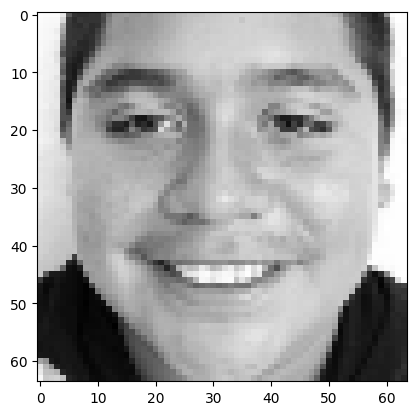

In [17]:
# Displaying an Image from the Dataset:

idx = 700
sample = images[idx]
print("Gender:",genders[idx],"Age:",ages[idx])
display(sample)

In [18]:
# Function for defining the Age Groups:

def age_group(age):
    if age >=0 and age < 18:
        return 1
    elif age < 30:
        return 2
    elif age < 80:
        return 3
    else:
        return 4

In [19]:
# Pre-processing:

target = np.zeros((size,2),dtype='float32')
features = np.zeros((size,sample.shape[0],sample.shape[1],1),dtype = 'float32')
for i in range(size):
    target[i,0] = age_group(int(ages[i])) / 4
    target[i,1] = int(genders[i])
    features[i] = images[i]

features = features / 255

In [ ]:
display(features[550])

In [20]:
# Splitting the Original Dataset into Training and Testing Dataset:

x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2,shuffle  = True)
print("Samples in Training:",x_train.shape[0])
print("Samples in Testing:",x_test.shape[0])

Samples in Training: 18966
Samples in Testing: 4742


In [21]:
# Defining the Model Layers:

inputs = Input(shape=(64,64,1))
conv1 = Conv2D(32, kernel_size=(3, 3),activation='relu')(inputs)
conv2 = Conv2D(64, kernel_size=(3, 3),activation='relu')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, kernel_size=(3, 3),activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv3)
x = Dropout(0.25)(pool2)
flat = Flatten()(x)

dropout = Dropout(0.5)
age_model = Dense(128, activation='relu')(flat)
age_model = dropout(age_model)
age_model = Dense(64, activation='relu')(age_model)
age_model = dropout(age_model)
age_model = Dense(32, activation='relu')(age_model)
age_model = dropout(age_model)
age_model = Dense(1, activation='relu')(age_model)

dropout = Dropout(0.5)
gender_model = Dense(128, activation='relu')(flat)
gender_model = dropout(gender_model)
gender_model = Dense(64, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(32, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(16, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(8, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(1, activation='sigmoid')(gender_model)

In [22]:
# Compiling the Model:

model = Model(inputs=inputs, outputs=[age_model,gender_model])
model.compile(optimizer = 'adam', loss =['mse','binary_crossentropy'],metrics=['accuracy'])

In [23]:
# Summary of the Model:

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 62, 62, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 60, 60, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 30, 30, 64)   0           ['conv2d_1[0][0]']               
                                                                                              

In [25]:
# Training the Model:

h = model.fit(x_train,[y_train[:,0],y_train[:,1]],validation_data=(x_test,[y_test[:,0],y_test[:,1]]),epochs = 40, batch_size=128,shuffle = True)

Epoch 1/40
149/149 [==============================] - 198s 1s/step - loss: 0.3604 - dense_3_loss: 0.0209 - dense_9_loss: 0.3394 - dense_3_accuracy: 0.0275 - dense_9_accuracy: 0.8598 - val_loss: 0.2688 - val_dense_3_loss: 0.0177 - val_dense_9_loss: 0.2511 - val_dense_3_accuracy: 0.0308 - val_dense_9_accuracy: 0.8967
Epoch 2/40
149/149 [==============================] - 198s 1s/step - loss: 0.3545 - dense_3_loss: 0.0208 - dense_9_loss: 0.3337 - dense_3_accuracy: 0.0274 - dense_9_accuracy: 0.8583 - val_loss: 0.2665 - val_dense_3_loss: 0.0185 - val_dense_9_loss: 0.2481 - val_dense_3_accuracy: 0.0308 - val_dense_9_accuracy: 0.9011
Epoch 3/40
149/149 [==============================] - 198s 1s/step - loss: 0.3413 - dense_3_loss: 0.0202 - dense_9_loss: 0.3211 - dense_3_accuracy: 0.0276 - dense_9_accuracy: 0.8659 - val_loss: 0.2693 - val_dense_3_loss: 0.0182 - val_dense_9_loss: 0.2511 - val_dense_3_accuracy: 0.0308 - val_dense_9_accuracy: 0.8973
Epoch 4/40
149/149 [=============================

In [26]:
# Saving the Model:

model.save('data.h5')

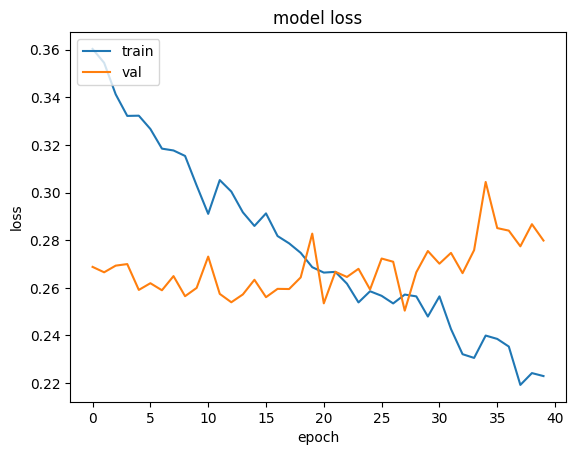

In [27]:
# Plotting the Training and the Validation Losses:

history = h
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [28]:
# Defining the functions for getting the Predictions:

def get_age(distr):
    distr = distr*4
    if distr >= 0.65 and distr <= 1.4:return "0-18"
    if distr >= 1.65 and distr <= 2.4:return "19-30"
    if distr >= 2.65 and distr <= 3.4:return "31-80"
    if distr >= 3.65 and distr <= 4.4:return "80 +"
    return "Unknown"
    
def get_gender(prob):
    if prob < 0.5:return "Male"
    else: return "Female"

def get_result(sample):
    sample = sample/255
    val = model.predict( np.array([ sample ]) )    
    age = get_age(val[0])
    gender = get_gender(val[1])
    print("Values:",val,"\nPredicted Gender:",gender,"Predicted Age:",age)

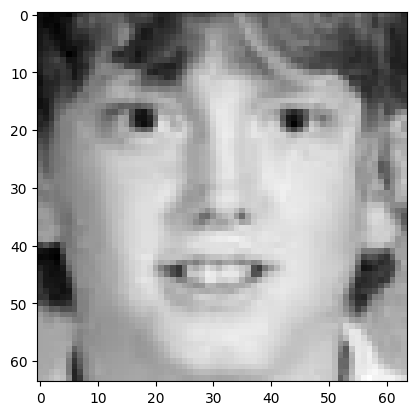

Actual Gender: Male Age: 14
1/1 [==============================] - 3s 3s/step
Values: [array([[0.28015384]], dtype=float32), array([[0.26072028]], dtype=float32)] 
Predicted Gender: Male Predicted Age: 0-18


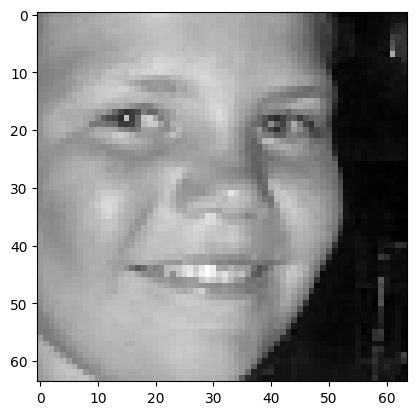

Actual Gender: Male Age: 10
1/1 [==============================] - 0s 41ms/step
Values: [array([[0.2807278]], dtype=float32), array([[0.34974098]], dtype=float32)] 
Predicted Gender: Male Predicted Age: 0-18


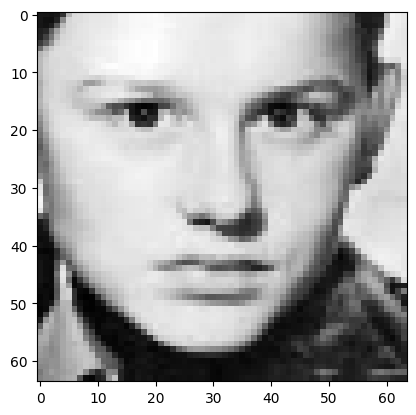

Actual Gender: Male Age: 10
1/1 [==============================] - 0s 28ms/step
Values: [array([[0.28224757]], dtype=float32), array([[0.47441074]], dtype=float32)] 
Predicted Gender: Male Predicted Age: 0-18


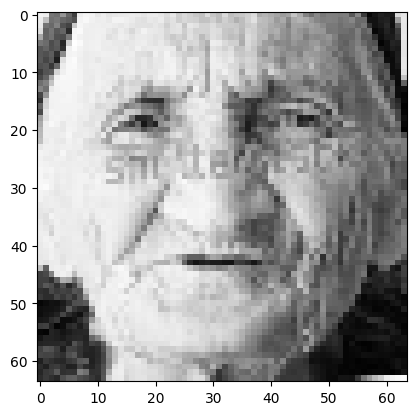

Actual Gender: Female Age: 100
1/1 [==============================] - 0s 38ms/step
Values: [array([[0.78461975]], dtype=float32), array([[0.6131363]], dtype=float32)] 
Predicted Gender: Female Predicted Age: 31-80


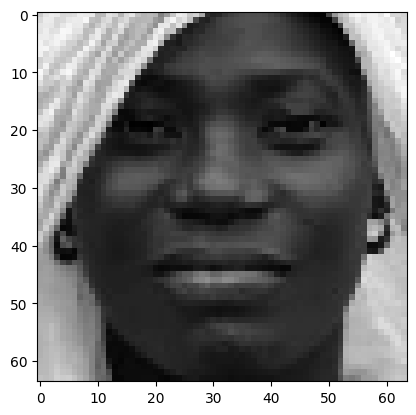

Actual Gender: Female Age: 24
1/1 [==============================] - 0s 30ms/step
Values: [array([[0.6868467]], dtype=float32), array([[0.9920247]], dtype=float32)] 
Predicted Gender: Female Predicted Age: 31-80


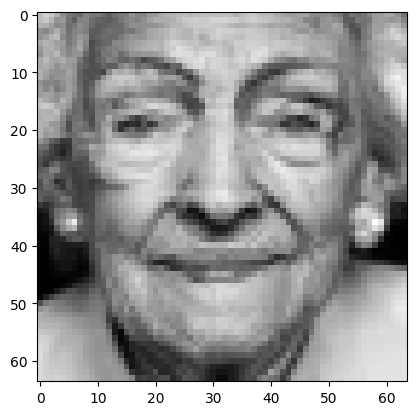

Actual Gender: Female Age: 100
1/1 [==============================] - 0s 31ms/step
Values: [array([[0.82900244]], dtype=float32), array([[0.8340084]], dtype=float32)] 
Predicted Gender: Female Predicted Age: 31-80


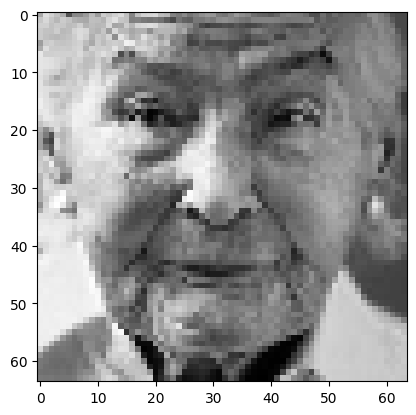

Actual Gender: Female Age: 100
1/1 [==============================] - 0s 31ms/step
Values: [array([[0.78548]], dtype=float32), array([[0.82508534]], dtype=float32)] 
Predicted Gender: Female Predicted Age: 31-80


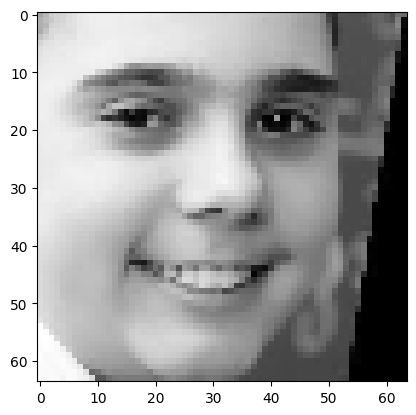

Actual Gender: Male Age: 12
1/1 [==============================] - 0s 30ms/step
Values: [array([[0.2804792]], dtype=float32), array([[0.01604828]], dtype=float32)] 
Predicted Gender: Male Predicted Age: 0-18


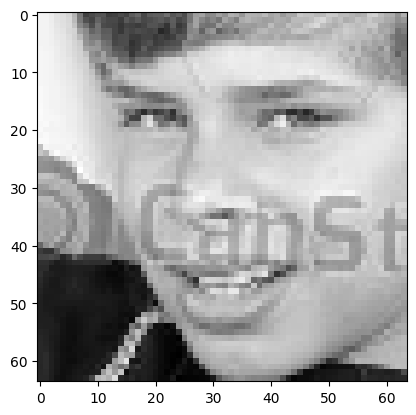

Actual Gender: Male Age: 10
1/1 [==============================] - 0s 31ms/step
Values: [array([[0.28485942]], dtype=float32), array([[1.8315275e-05]], dtype=float32)] 
Predicted Gender: Male Predicted Age: 0-18


In [29]:
# Taking the predictions for a set of sample data points:

indexes = [500,59,80,2,4546,7,9,256,45]
for idx in indexes:
    sample = images[idx]
    display(sample)
    print("Actual Gender:",get_gender(genders[idx]),"Age:",ages[idx])
    res = get_result(sample)